 <p style = "font-size: 35px;font-weight: bold;text-align:center;color:#800000"> Engagement/Intent Metrics vs Ecosure Violations (Brand Level) </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 07/05/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures at brand level. We are comparing audits data with engagement and intent metrics.<br>

Data Used: <br>
* For <b>Audit Information</b>, across different brands, we have used <b>Ecosure BI Data</b> stored in <b>SQLServer</b>
* For <b>Engagement Information</b>, across different brands, we have used <b>Yelp API</b>
* Across all 19 brands <b>("Applebee's", "Friendly's", 'IHOP,' 'Margaritaville', 'Noodles & Co.',
 'On the Border', 'Panera', 'Twin Peaks', 'Buffalo Wild Wings',
 "Famous Dave's of America,  Inc.", 'Cafe Zupas', 'Benihana National Corp',
 'WingStop', 'Texas Roadhouse', 'True Food Kitchen', 'Ruby Tuesday Inc.',
 "O'Charley's, Inc.", 'Modern Market', 'Wood Ranch')</b>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import re
import string
import datetime
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.4f}'.format

## Pre-processing Engagement Metrics Data

In [3]:
######################################################## Engagement/Intent Metrics ######################################################
#########################################################################################################################################

csv_names = ['Applebee_engagement.csv', 'Benihana_engagement.csv', 'BuffaloWildWings_engagement.csv', 'CafeZupas_engagement.csv',
             'FamousDave_engagement.csv', 'Friendly_engagement.csv', 'IHOP_engagement.csv', 'Margaritaville_engagement.csv',
             'ModernMarket_engagement.csv', 'Noodles&Co._engagement.csv', 'OCharley_engagement.csv', 'OntheBorder_engagement.csv',
             'Panera_engagement.csv', 'RubyTuesday_engagement.csv', 'TexasRoadhouse_engagement.csv', 'TrueFoodKitchen_engagement.csv',
             'TwinPeaks_engagement.csv', 'WingStop_engagement.csv', 'WoodRanch_engagement.csv']

list_metrics = []
for i in csv_names:
    list_metrics.append(pd.read_csv('/User/yelpapi/Engagement_Metric/%s' %(i)))

df_engagement = pd.concat(list_metrics)
df_engagement.drop(df_engagement.filter(regex="Unname"),axis=1, inplace=True)
df_engagement.reset_index(drop=True, inplace=True)

In [4]:
df_engagement['metrics.start_of_week_date'] = pd.to_datetime(df_engagement['metrics.start_of_week_date'], errors='coerce')
df_engagement['month_year'] = df_engagement['metrics.start_of_week_date'].apply(lambda x: x.strftime('%B-%Y'))

df_engagement['Week_Number'] = df_engagement['metrics.start_of_week_date'].dt.week
df_engagement['Year'] = df_engagement['metrics.start_of_week_date'].dt.year
df_engagement['Week_No_Year'] = df_engagement['Week_Number'].astype(str) + '-' + df_engagement['Year'].astype(str)

df_grouped_eng = df_engagement.groupby(['month_year', 'Brand'], as_index=False).agg({'metrics.engagement_metric' : 'mean', 'metrics.intent_metric' : 'mean'})
df_grouped_eng.rename({'metrics.engagement_metric' : 'Engagement_Metric', 'metrics.intent_metric' : 'Intent_Metric'}, axis=1, inplace=True)

## Pre-processing Audit Data

In [5]:
######################################################### Audit Data ###################################################################
########################################################################################################################################
# read aggregated audit data
df_audit = pd.read_csv('/User/csv/Audit/Ecosure_Processed-0.csv')
df_audit.drop(df_audit.filter(regex="Unname"),axis=1, inplace=True)

df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit = df_audit[df_audit.AuditStarted.notnull()]
df_audit['Date'] = df_audit['AuditStarted'].dt.date

df_audit['Week_Number'] = df_audit['AuditStarted'].dt.week
df_audit['Year'] = df_audit['AuditStarted'].dt.year
df_audit['Week_No_Year'] = df_audit['Week_Number'].astype(str) + '-' + df_audit['Year'].astype(str)

df_audit['month_year'] = df_audit['AuditStarted'].apply(lambda x: x.strftime('%B-%Y'))
df_audit['Total_No_of_Violations_per_question'] = df_audit['Total_Violations']/df_audit['count_questions']

In [6]:
# aggregating violations data
df_violations = df_audit.groupby(['month_year', 'ClientName'], as_index=False).agg({'Total_No_of_Violations_per_question' : 'mean', 'TranslatedScore' : 'mean', 
                                                                                      'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'TranslatedScore' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

df_violations.reset_index(drop=True, inplace=True)

In [7]:
map_brands = {'Applebees' : "Applebee's", 'Benihana National Corp' : 'Benihana National Corp', 'Buffalo Wild Wings' : 'Buffalo Wild Wings',
              'Cafe Zupas' : 'Cafe Zupas', 'Famous Daves of America,  Inc.' : "Famous Dave's of America,  Inc.", 'IHOP' : 'IHOP',
              'Friendlys' : "Friendly's", 'Margaritaville' : 'Margaritaville', 'Noodles & Co.' : 'Noodles & Co.', 'OCharleys' : "O'Charley's, Inc.",
              'On the Border' : 'On the Border', 'Panera' : 'Panera', 'Ruby Tuesday Inc.' : 'Ruby Tuesday Inc.', 'Texas Roadhouse' : 'Texas Roadhouse',
              'True Food Kitchen' : 'True Food Kitchen', 'Twin Peaks' : 'Twin Peaks', 'WingStop' : 'WingStop', 'Wood Ranch' : 'Wood Ranch',
              'Modern Market' : 'Modern Market'}

df_grouped_eng['Brand'] = df_grouped_eng['Brand'].map(map_brands)

In [8]:
############################################# Merging Both the Datasets #################################################################
#########################################################################################################################################

df_merged = pd.merge(df_violations, df_grouped_eng, how='inner', on=['month_year', 'Brand'])

df_merged.dropna(how = 'any', axis=0, inplace=True)
df_merged.reset_index(drop=True, inplace=True)


# Adding KPI for normalised store
grouped_brands = df_audit.groupby(['ClientName']).agg({'State': pd.Series.nunique ,
                                                       'City': pd.Series.nunique,
                                                       'StoreName':pd.Series.nunique,
                                                       'ClientID': 'count' }).reset_index()
dicti = dict(zip(list(grouped_brands.ClientName), list(grouped_brands.StoreName)))

def kpi_audit_store(brand, audits):
    return (audits/dicti[brand])

df_merged['Audit_per_store'] = df_merged.apply(lambda x: kpi_audit_store(x['Brand'], x['No_of_Audits']), axis=1)

In [9]:
###################################################### REQUIRED INTERVAL #################################################
def req_intervals(x):
    if (x < -0.5) & (x > -1):
        return 'Score (-0.5 to -1)'
    elif (x < 0) & (x > -0.5):
        return 'Score (-0.5 to 0)'
    elif (x < 0.5) & (x > 0):
        return 'Score (0 to 0.5)'
    else:
        return 'Score (0.5 to 1)'
    

######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def spearman_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(df_datagrouped[df_datagrouped.Brand == brand][test_var], 
                         df_datagrouped[df_datagrouped.Brand == brand][measure])
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

In [10]:
print("Total No of brands retained :", df_merged.Brand.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", list(df_merged.Brand.unique()))

Total No of brands retained : 19

 

Name's of the brands used for analysis: ["Applebee's", 'Benihana National Corp', 'Buffalo Wild Wings', 'Cafe Zupas', 'IHOP', 'Margaritaville', 'Noodles & Co.', 'On the Border', 'Panera', 'Twin Peaks', "Friendly's", 'True Food Kitchen', "O'Charley's, Inc.", 'Ruby Tuesday Inc.', 'Modern Market', 'Wood Ranch', 'WingStop', 'Texas Roadhouse', "Famous Dave's of America,  Inc."]


## Approach 1: Brand Level Analysis
### Ranked Correlation Analysis

In [11]:
def spearmanr_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    from scipy.stats import spearmanr
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr, p_values = [], []
    lengthdata = []
    
    for brand in brands:
        corr,p = spearmanr(np.array(df_datagrouped[df_datagrouped.Brand == brand][test_var]), 
                         np.array(df_datagrouped[df_datagrouped.Brand == brand][measure]))
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
        p_values.append(p)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'P Values': p_values,
                            'Correlation Coefficient': spearman_corr
                            })
    # inplace
    test_df.replace(np.nan, 0, inplace=True)
    
    return test_df

### Total No of Violations per Question vs Sentiment Score

<b>7 out of the 18 brands show negative correlations with Engagement Metric </b>

In [12]:
spearmanr_corr_brand(df_merged, 'Total_No_of_Violations_per_question', 'Engagement_Metric')

,Brand,Data Points,P Values,Correlation Coefficient
0,Applebee's,53,0.0024,0.4087
1,Benihana National Corp,50,0.0000,0.0000
2,Buffalo Wild Wings,49,0.0000,0.8077
3,Cafe Zupas,52,0.7887,-0.0381
4,IHOP,54,0.3148,0.1394
5,Margaritaville,53,0.0128,0.3399
6,Noodles & Co.,56,0.0003,0.4666
7,On the Border,46,0.0716,-0.2681
8,Panera,55,0.0010,0.4317
9,Twin Peaks,47,0.0248,0.3271


### Total No of Violations per Question vs Ratings

<b>7 out of the 18 brands show negative correlations with Intent Metric from Yelp </b>

In [13]:
spearmanr_corr_brand(df_merged, 'Total_No_of_Violations_per_question', 'Intent_Metric')

,Brand,Data Points,P Values,Correlation Coefficient
0,Applebee's,53,0.2437,0.1630
1,Benihana National Corp,50,0.0000,0.0000
2,Buffalo Wild Wings,49,0.0000,0.7948
3,Cafe Zupas,52,0.0262,0.3082
4,IHOP,54,0.3324,-0.1344
5,Margaritaville,53,0.0038,0.3908
6,Noodles & Co.,56,0.3821,0.1191
7,On the Border,46,0.0034,0.4234
8,Panera,55,0.0000,0.5332
9,Twin Peaks,47,0.0177,0.3445


# Approach 3: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b> some negative correlation between Violations per Audit and Customer Sentiment Measures</b>
* With more <b>Refined Dataset</b>, the <b>correlation do not become strong between our Drivers(Mean Audit Score, Violations per question) and Measures of Delighted Guests(Sentiment Score, Ratings) </b>

In [14]:
def add_lag_lead(df, var_name, brand_name):
    df = df[df['Brand'] == brand_name].reset_index(drop=True)
    df[var_name+"_lag1"] = df[var_name].shift(1)
    df[var_name+"_lead1"] = df[var_name].shift(-1)
    df[var_name+"_lag2"] = df[var_name].shift(2)
    df[var_name+"_lead2"] = df[var_name].shift(-2)
    df[var_name+"_lag3"] = df[var_name].shift(3)
    df[var_name+"_lead3"] = df[var_name].shift(-3)
    
    return df

def add_only_lag_lead(df, var_name):
    df[var_name+"_lag1"] = df[var_name].shift(1)
    df[var_name+"_lead1"] = df[var_name].shift(-1)
    df[var_name+"_lag2"] = df[var_name].shift(2)
    df[var_name+"_lead2"] = df[var_name].shift(-2)
    df[var_name+"_lag3"] = df[var_name].shift(3)
    df[var_name+"_lead3"] = df[var_name].shift(-3)
    
    return df

In [15]:
df_applebee = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Applebee's")
df_applebee = add_only_lag_lead(df_applebee, 'Mean_Audit_Score')
df_fd = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Famous Dave's of America,  Inc.")
df_fd = add_only_lag_lead(df_fd, 'Mean_Audit_Score')
df_f = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Friendly's")
df_f = add_only_lag_lead(df_f, 'Mean_Audit_Score')
df_ihop = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'IHOP')
df_ihop = add_only_lag_lead(df_ihop, 'Mean_Audit_Score')
df_mar = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Margaritaville')
df_mar = add_only_lag_lead(df_mar, 'Mean_Audit_Score')
df_noo = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Noodles & Co.')
df_noo = add_only_lag_lead(df_noo, 'Mean_Audit_Score')
df_otb = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'On the Border')
df_otb = add_only_lag_lead(df_otb, 'Mean_Audit_Score')
df_pan = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Panera')
df_pan = add_only_lag_lead(df_pan, 'Mean_Audit_Score')
df_twi = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Twin Peaks') 
df_twi = add_only_lag_lead(df_twi, 'Mean_Audit_Score')
df_bww = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Buffalo Wild Wings') 
df_bww = add_only_lag_lead(df_bww, 'Mean_Audit_Score')
df_cz = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Cafe Zupas')
df_cz = add_only_lag_lead(df_cz, 'Mean_Audit_Score')
df_ws = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'WingStop')
df_ws = add_only_lag_lead(df_ws, 'Mean_Audit_Score')
df_tr = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Texas Roadhouse')
df_tr = add_only_lag_lead(df_tr, 'Mean_Audit_Score')
df_tfk = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'True Food Kitchen')
df_tfk = add_only_lag_lead(df_tfk, 'Mean_Audit_Score')
df_rt = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Ruby Tuesday Inc.')
df_rt = add_only_lag_lead(df_rt, 'Mean_Audit_Score')
df_oc = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "O'Charley's, Inc.")
df_oc = add_only_lag_lead(df_oc, 'Mean_Audit_Score')
df_mm = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Modern Market')
df_mm = add_only_lag_lead(df_mm, 'Mean_Audit_Score')
df_beni = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Benihana National Corp')
df_beni = add_only_lag_lead(df_beni, 'Mean_Audit_Score')
df_wr = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Wood Ranch')
df_wr = add_only_lag_lead(df_wr, 'Mean_Audit_Score')

In [16]:
df_merged_1 = df_applebee.append([df_fd, df_f, df_ihop, df_mar,
                                  df_noo, df_otb, df_pan, df_twi,
                                  df_bww, df_cz, df_ws, df_tr,
                                  df_tfk, df_rt, df_oc, df_mm,
                                  df_beni, df_wr])
df_merged_1.dropna(axis=0, how='any', inplace=True)
df_merged_1.reset_index(drop=True, inplace=True)

In [17]:
df_merged_1.columns

Index(['month_year', 'Brand', 'Total_No_of_Violations_per_question', 'Mean_Audit_Score', 'No_of_Audits', 'Engagement_Metric', 'Intent_Metric', 'Audit_per_store', 'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lag2', 'Total_No_of_Violations_per_question_lead2', 'Total_No_of_Violations_per_question_lag3', 'Total_No_of_Violations_per_question_lead3', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lag2', 'Mean_Audit_Score_lead2', 'Mean_Audit_Score_lag3', 'Mean_Audit_Score_lead3'], dtype='object')

##  Correlation Matrix

### Data Aggregated at Month Year, Brand & Location Level

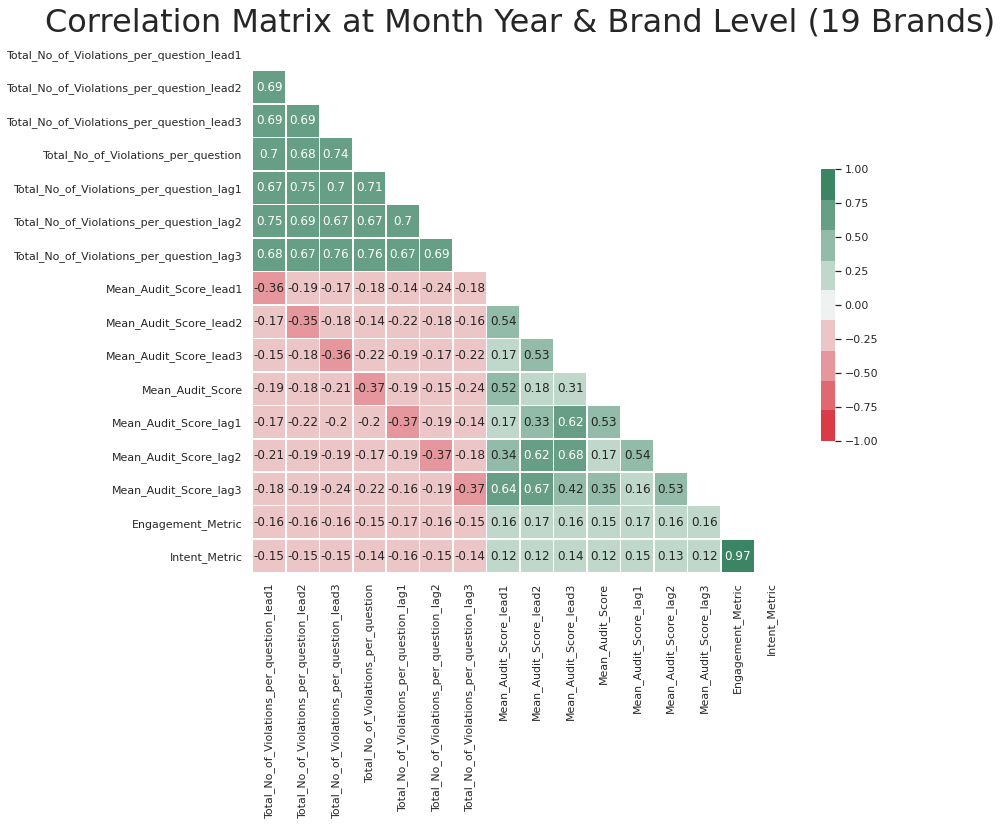

In [18]:
var = ['Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lead2',
       'Total_No_of_Violations_per_question_lead3', 'Total_No_of_Violations_per_question',
       'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lag2',
       'Total_No_of_Violations_per_question_lag3', 'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lead2',
       'Mean_Audit_Score_lead3', 'Mean_Audit_Score', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lag2', 
       'Mean_Audit_Score_lag3', 'Engagement_Metric', 'Intent_Metric']

correlation_matrix(var, df_merged_1, "Correlation Matrix at Month Year & Brand Level (19 Brands)")